In [1]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as la
%matplotlib inline
from matplotlib import pyplot as plt
# %matplotlib notebook



In [2]:
# Definir nuestro sistema.
f=5.
dt=0.1
g=9.8
Z = 100
A = np.array([[1,0,dt,0,0],[0,1,0,dt,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]], dtype=float) #"Matriz" de transicion de estado.
B = np.array([0,dt**2,0,0,-2/g], dtype=float).transpose() #"Matriz" de control.
H = np.array([[1000/Z,0,0,0,960],[0,1000/Z,0,0,540]], dtype=float) #"Matriz" de medición.
P = 1*np.eye(5, dtype=float) #"Matriz" de incertidumbre del estado.
Q = 1e-9*np.eye(5, dtype=float) #"Matriz" de incertidumbre de la predicción.
R = (4/9)*np.eye(2, dtype=float) #"Matriz" de incertidumbre de la medición.

K = np.array([[1000,0,960],[0,1000,540],[0,0,1]],dtype=float)
Uc = -g/2

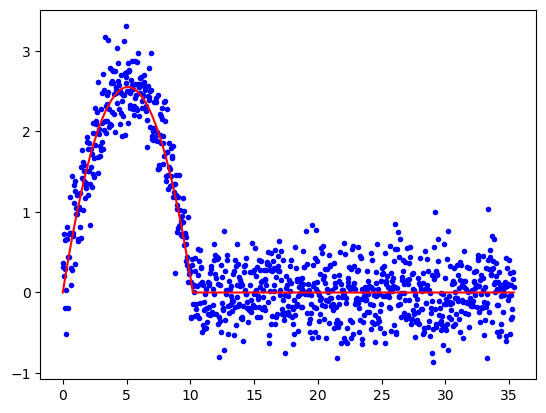

In [14]:
#Generar datos aleatorios.

xo = yo = 0
theta = 45 * np.pi/180
vo = 10
vox = vo * np.cos(theta)
voy = vo * np.sin(theta)

#Aqui hay que terminar de desarrollar el sistema para generar las mediciones y añadirles ruido
# Z= ...
# Número de mediciones
N = 1000
t = np.linspace(0,5, N)

# Posición en función del tiempo
x = vox * t
y = voy * t - 0.5 * g * t**2
# Evitar valores negativos de y (la bala no puede caer por debajo del suelo)
y = np.maximum(y, 0)

# mediciones con ruido Gaussiano de la medicion
noise = rnd.randn(N) * np.sqrt(1e-1)
yn= y + noise

# Graficamos
plt.figure(1)
plt.plot(x, yn, 'b.', x, y, 'r')

In [15]:
# $\hat{x}_{k-1}$ => xhat_k0
# $\hat{x}_{k}$ => xhat_k1
# $\bar{x}_{k}$ => xbar_k1

def KalmanFilter (Xhat_k0, Phat_k0, U_k1, Z_k, A, B, H, Q, R):
    #Predicción
    Xbar_k1 = np.dot(A, Xhat_k0) + np.dot(B, U_k1)
    Pbar_k1 = np.dot(A, np.dot(Phat_k0, A.transpose()))+Q
    
    #Actualización
    
    #Calculamos la ganancia.
    denom = np.dot(np.dot(H, Pbar_k1), H.transpose())+R
    if len(denom) > 1:
        denom = la.inv(denom)
    else:
        denom = 1. / denom
    Kgain = np.dot(np.dot(Pbar_k1, H.transpose()),denom)
    
    # Actualizamos el Estado y su incertidumbre.
    Xhat_k1 = Xbar_k1 + np.dot(Kgain, (Z_k- np.dot(H, Xbar_k1)))
    Phat_k1 = np.dot(np.eye(len(Xhat_k0))-np.dot(Kgain,H), Pbar_k1)
    
    return Xhat_k1, Phat_k1

In [21]:
#definimos un valor inicial y su incertidumbre estimada (Mat. Cov).
valor = 7
Vn = yn
V = y


x = (valor + rnd.randn(1)*np.sqrt(Q[0])) / H

P = np.array([0.1], dtype=float)

#Definimos matrices para almacenar la evolucion del sistema.
Xhat=np.zeros((N, 1))
Phat=np.zeros((N, 1))

#Inicializamos valor 0 de la estimacion del estado y su incertidumbre (Mat. Cov)
Xhat[0,0], Phat[0,0] = x, P

#Esta Matriz almacenará el estado calculado por medios convencionales (el promedio)
xSim = np.zeros(t.shape)
xSim[0] = x

for idx in range(1,N):
    Z = Vn[idx] #Obtenemos una medicion.
    
    #Claculamos el promedio del estado a partir de las mediciones que tenemos.
    xSim[idx] = np.mean(Vn[:idx])/H
    
    Xhat[idx,0], Phat[idx,0] = KalmanFilter (Xhat[idx-1], Phat[idx-1], 0, Z, A, B, H, Q, R)

C:\Users\ruben\AppData\Local\Temp\ipykernel_12948\1908769055.py:27: RuntimeWarning: divide by zero encountered in divide
  xSim[idx] = np.mean(Vn[:idx])/H


ValueError: setting an array element with a sequence.

<IPython.core.display.Javascript object>


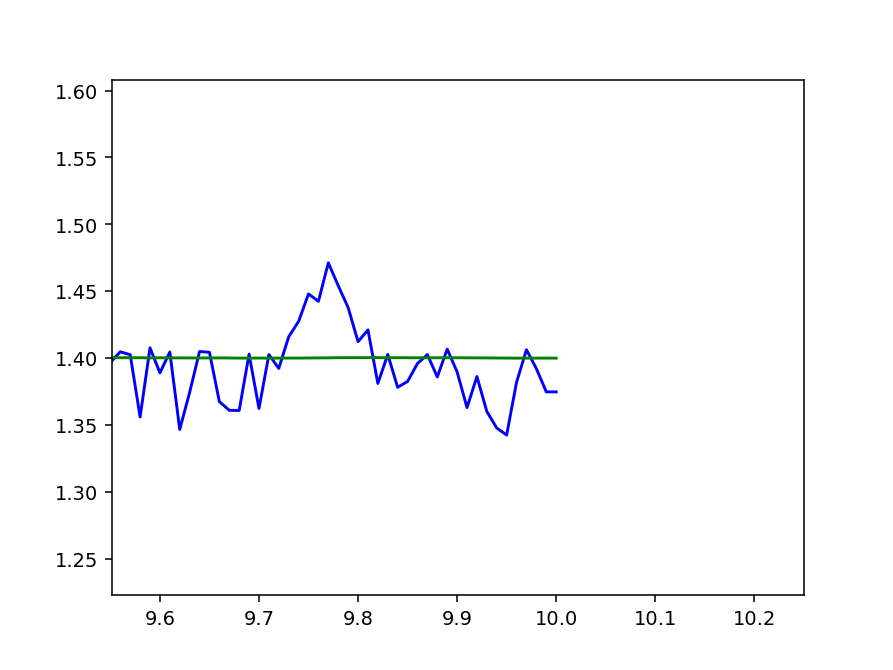

In [12]:

plt.figure(2)
plt.plot(t, Vn, 'k.', t, V, 'r', t, Xhat, 'b', t, xSim, 'g')




<IPython.core.display.Javascript object>


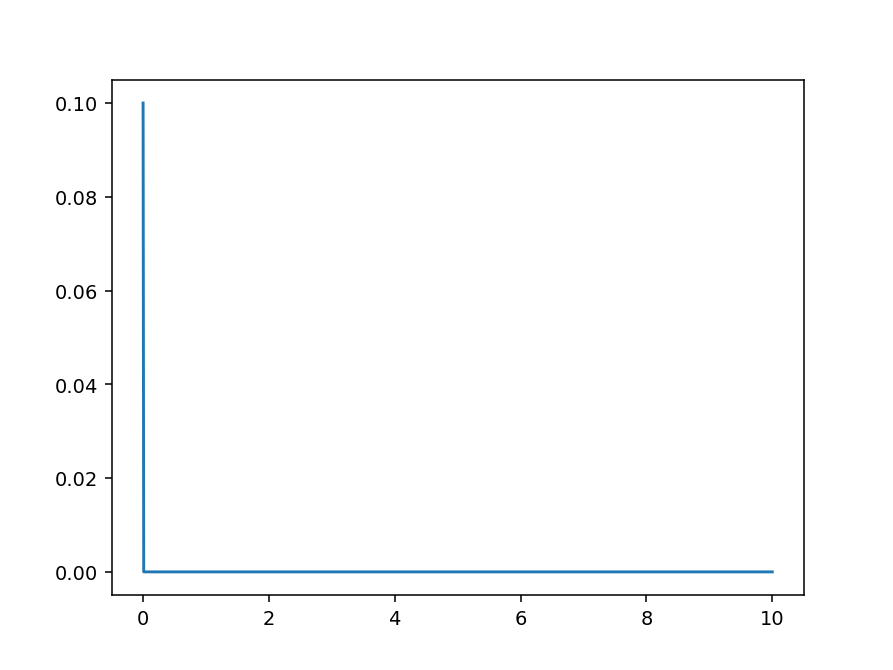

In [13]:
plt.figure(3)
plt.plot(t, Phat)